In [8]:
%matplotlib inline
from astropy.io import fits
import astropy.wcs as wcs
import numpy as np
import matplotlib.pyplot as plt

In [2]:
filename = '/Users/yaolun/test/hpacs1342224922_20hpppmapr_00_1431606963820.fits'
rrange = [10, 200]
annulus_width = 10

In [10]:
from astropy import units as u
from astropy.coordinates import SkyCoord
c = SkyCoord('12 01 36.81 -65 08 49.22', unit=(u.hourangle, u.deg))

## Read in the image

In [52]:
hdu_im = fits.open(filename)
im = hdu_im[1].data
w = wcs.WCS(hdu_im[1].header)
# get the pixel coordinates of the source
pixcoord = w.wcs_world2pix(c.ra.degree, c.dec.degree, 1)
pix2arcsec = abs(hdu_im[1].header['CDELT1'])*3600

# number count array
im_count = np.ones_like(im)

In [35]:
# determine whether need to convert the unit
factor = 1
print 'Image unit is ', hdu_im[1].header['BUNIT']
if hdu_im[1].header['BUNIT'] != 'Jy/pixel':
    print 'Image unit is ', hdu_im[1].header['BUNIT']

    if hdu_im[1].header['BUNIT'] == 'MJy/sr':
        # convert intensity unit from MJy/sr to Jy/pixel
        factor = 1e6/4.25e10*abs(hdu_im[1].header['CDELT1']*hdu_im[1].header['CDELT2'])*3600**2
    else:
        factor = raw_input('What is the conversion factor to Jy/pixel?')

Image unit is  Jy/pixel


In [45]:
r = np.arange(rrange[0], rrange[1], annulus_width, dtype=float)
unc = np.empty_like(r)
phot_buffer = []

# construct the x- and y-matrix
grid_x, grid_y = np.meshgrid(np.linspace(0,len(im[0,:])-1,len(im[0,:])), 
                             np.linspace(0,len(im[:,0])-1,len(im[:,0])))

dist_x = abs(grid_x - (len(im[:,0]-1)/2.))
dist_y = abs(grid_y - (len(im[0,:]-1)/2.))

grid_dist = ((grid_x-pixcoord[0])**2+(grid_y-pixcoord[1])**2)**0.5

for ir in range(len(r)-1):
    im_dum = np.where((grid_dist < r[ir+1]/pix2arcsec) & (grid_dist >= r[ir]/pix2arcsec), im, np.nan)
    im_count_dum = np.where((grid_dist < r[ir+1]/pix2arcsec) & (grid_dist >= r[ir]/pix2arcsec), im_count, np.nan)
#     print np.nanstd(im_dum), np.nansum(im_count_dum)
    print np.nanstd(im_dum)*factor/np.nansum(im_count_dum)

0.920406830303
0.169085495528
0.0252899564406
0.0164453941391
0.0107428722111
0.00836495362988
0.00701115426249
0.0052473191903
0.00420202627999
0.00354440290677
0.00258671690213
0.00212275946589
0.00215535338653
0.00209375426536
0.00164385943651
0.00159477178125
0.00188858381145
0.00245210252662


In [43]:
from photutils import aperture_photometry as ap
from photutils import CircularAperture, CircularAnnulus

for ir in range(len(r)-1):
    aperture = CircularAnnulus((pixcoord[0],pixcoord[1]), r_in=r[ir]/pix2arcsec, r_out=r[ir+1]/pix2arcsec)
    phot = ap(im, aperture)
    print aperture.area()
#     I[ir] = phot['aperture_sum'].data * factor / aperture.area()
#     I_err[ir] = phot['aperture_sum_err'].data * factor / aperture.area()

92.0388472731
153.398078789
214.757310304
276.116541819
337.475773335
398.83500485
460.194236366
521.553467881
582.912699397
644.271930912
705.631162427
766.990393943
828.349625458
889.708856974
951.068088489
1012.42732
1073.78655152
1135.14578304


## Take a different approach

Vary the radius by a pixel to see how sensitive of the enclosed flux to the position

In [55]:
from photutils import aperture_photometry as ap
from photutils import CircularAperture, CircularAnnulus

In [68]:
offset = 0
r = np.arange(rrange[0], rrange[1], annulus_width, dtype=float) + offset*pix2arcsec
I = np.empty_like(r[:-1])

for ir in range(len(r1)-1):
    aperture = CircularAnnulus((pixcoord[0],pixcoord[1]), r_in=r[ir]/pix2arcsec, r_out=r[ir+1]/pix2arcsec)
    phot = ap(im, aperture)
    I[ir] = phot['aperture_sum'].data * factor / aperture.area()

In [67]:
offset = -1
r1 = np.arange(rrange[0], rrange[1], annulus_width, dtype=float) + offset*pix2arcsec
I1 = np.empty_like(r[:-1])

for ir in range(len(r1)-1):
    aperture = CircularAnnulus((pixcoord[0],pixcoord[1]), r_in=r1[ir]/pix2arcsec, r_out=r1[ir+1]/pix2arcsec)
    phot = ap(im, aperture)
    I1[ir] = phot['aperture_sum'].data * factor / aperture.area()

In [66]:
offset = 1
r2 = np.arange(rrange[0], rrange[1], annulus_width, dtype=float) + offset*pix2arcsec
I2 = np.empty_like(r[:-1])

for ir in range(len(r1)-1):
    aperture = CircularAnnulus((pixcoord[0],pixcoord[1]), r_in=r2[ir]/pix2arcsec, r_out=r2[ir+1]/pix2arcsec)
    phot = ap(im, aperture)
    I2[ir] = phot['aperture_sum'].data * factor / aperture.area()

In [70]:
I_err = (abs(I1-I)**2 + abs(I2-I)**2)**0.5

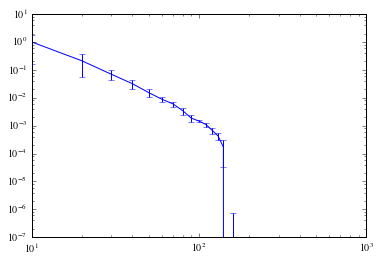

In [74]:
plt.errorbar(r[:-1], I/I.max(), yerr=I_err/I.max())
plt.yscale('log')
plt.xscale('log')